In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel, AutoModel
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from torch.optim import AdamW
# 
from src.data.dataset import EssayDataset
from src.data.longDataset import LongEssayDataset
from src.models.regressionModel import RegressionModel
from src.models.hierarchicalBert import HierarchicalBert

### Merge dataset

In [2]:
# df1 = pd.read_csv("data/analisis_essay.csv")
# df1['dataset'] = 'analisis_essay'
# df2 = pd.read_csv("data/asap.csv")
# df2['dataset'] = 'asap'
# df3 = pd.read_csv("data/cunlp.csv")
# df3['dataset'] = 'cunlp'
# df4 = pd.read_csv("data/sag.csv")
# df4['dataset'] = 'sag'
# df5 = pd.read_csv("data/sci.csv")
# df5['dataset'] = 'sci'
# df6 = pd.read_csv("data/stita.csv")
# df6['dataset'] = 'stita'

# # add null value to all dataframe that doesn't have question column
# for df in [df2, df3, df6]:
#     df['question'] = pd.NA

# df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
# df.shape

# df.to_csv("data/aes_dataset.csv", index=False)

### Preprocessing

In [2]:
df = pd.read_csv("../data/full_aes_dataset.csv")
df.head()

,question,reference_answer,answer,score,dataset,normalized_score,normalized_score2,bert_length,indobert_length,albert_length,longformer_length,multibert_length,indoalbert_length
0,Jelaskan kegunaan karbohidrat untuk tubuh kita.,Fungsi karbohidrat adalah sebagai pemasok ener...,"sumber tenaga, pemanis alami, menjaga sistem i...",27.0,analisis_essay,0.27,27,131,63,129,134,94,65
1,Jelaskan kegunaan karbohidrat untuk tubuh kita.,Fungsi karbohidrat adalah sebagai pemasok ener...,"sebagai sumber energi, pemanis alami, menjaga ...",21.0,analisis_essay,0.21,21,135,64,131,137,97,66
2,Jelaskan kegunaan karbohidrat untuk tubuh kita.,Fungsi karbohidrat adalah sebagai pemasok ener...,1. Sebagai energi. 2. Sebagai memperlancaar pe...,42.0,analisis_essay,0.42,42,148,74,146,148,105,76
3,Jelaskan kegunaan karbohidrat untuk tubuh kita.,Fungsi karbohidrat adalah sebagai pemasok ener...,"untuk membuat kenyang, agar tidak lapar, agar ...",18.0,analisis_essay,0.18,18,136,65,133,140,93,67
4,Jelaskan kegunaan karbohidrat untuk tubuh kita.,Fungsi karbohidrat adalah sebagai pemasok ener...,Karbohidrat mempunyai peran penting untuk pros...,82.0,analisis_essay,0.82,82,239,103,240,242,162,105


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22406 entries, 0 to 22405
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   question           4859 non-null   object 
 1   reference_answer   22406 non-null  object 
 2   answer             22406 non-null  object 
 3   score              22406 non-null  float64
 4   dataset            22406 non-null  object 
 5   normalized_score   22406 non-null  float64
 6   normalized_score2  22406 non-null  int64  
 7   bert_length        22406 non-null  int64  
 8   indobert_length    22406 non-null  int64  
 9   albert_length      22406 non-null  int64  
 10  longformer_length  22406 non-null  int64  
 11  multibert_length   22406 non-null  int64  
 12  indoalbert_length  22406 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 2.2+ MB


In [5]:
df['dataset'].value_counts()

dataset
asap              17043
sag                2558
analisis_essay     2162
stita               333
cunlp               171
sci                 139
Name: count, dtype: int64

In [6]:
# convert NaN to None
df['question'] = df['question'].replace({np.nan: None})

### Analysis Max Length of the Sub Token

In [7]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# dataset = EssayDataset(df, tokenizer, 512)

# df['max_length'] = df.index.map(dataset.get_max_length)
# len(df[(df['max_length'] > 510)])

In [8]:
tokenizer1 = BertTokenizer.from_pretrained("indobenchmark/indobert-lite-base-p2")
dataset = EssayDataset(df, tokenizer1, 512, "ALBERT")

df['max_length1'] = df.index.map(dataset.get_max_length)
len(df[(df['dataset'] != 'analisis_essay')&(df['max_length1'] > 510)])

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


308

In [9]:
df['max_length1'].describe()

count    22406.000000
mean       161.063688
std        108.950303
min         30.000000
25%        114.000000
50%        150.000000
75%        186.000000
max       1832.000000
Name: max_length1, dtype: float64

## Normalize Score

In [10]:
def normalize_score(row, min_max_dict):
    min_score, max_score = min_max_dict[row['dataset']]
    return int((row['score'] - min_score) / (max_score - min_score)*100)

# Menghitung min dan max per kategori sebagai tuple
min_max_dict = df.groupby('dataset')['score'].agg(['min', 'max']).apply(tuple, axis=1).to_dict()

# Menambahkan kolom normalized_score
df['normalized_score2'] = df.apply(lambda x: normalize_score(x, min_max_dict), axis=1)


In [11]:
df['normalized_score2'].describe()

count    22406.000000
mean        38.206552
std         33.824810
min          0.000000
25%          0.000000
50%         33.000000
75%         66.000000
max        100.000000
Name: normalized_score2, dtype: float64

## Training

In [12]:
df_sag = df[df['dataset'] == 'sag']
df_sag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2558 entries, 19376 to 21933
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   question           2558 non-null   object 
 1   reference_answer   2558 non-null   object 
 2   answer             2558 non-null   object 
 3   score              2558 non-null   float64
 4   dataset            2558 non-null   object 
 5   max_length1        2558 non-null   int64  
 6   normalized_score   2558 non-null   float64
 7   normalized_score2  2558 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 179.9+ KB


In [13]:
df_test = df_sag[:12]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 19376 to 19387
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   question           12 non-null     object 
 1   reference_answer   12 non-null     object 
 2   answer             12 non-null     object 
 3   score              12 non-null     float64
 4   dataset            12 non-null     object 
 5   max_length1        12 non-null     int64  
 6   normalized_score   12 non-null     float64
 7   normalized_score2  12 non-null     int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 864.0+ bytes


In [14]:
test = df[df['max_length1'] > 1000]

In [15]:
test_dataset = LongEssayDataset(test, tokenizer1, 512, 128)

In [16]:
dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=lambda x: list(zip(*x)))

In [17]:
for batch in dataloader:
    print(batch)
    break

[([{'input_ids': tensor([    2, 29791, 29950,  2293, 29835, 10948,  4012, 24045,     7, 29950,
        20887, 17732,   374,   223,  5718,  1742, 26544, 20718,   133,    48,
        19967, 14561,    10, 29946, 19998, 19425, 29840,  1002,  7012,    55,
        27952, 29950,    11, 29942,    10, 29943, 29953,   111, 20741,   101,
         1116,   918,  9689,  5707, 29946,    11, 29942,   253, 29943, 29953,
          502,  1548, 20232,   630, 20741,   101,  1116, 29442, 29835,    11,
        29942,   253, 29855,   193, 29856, 29838, 29948, 29948, 29943, 29953,
           11, 29942,   253, 29855, 29943, 29945,    11, 29942,   253, 29856,
        29943, 29948, 29948, 29948,  1548, 20232,   630, 27807,  2754,  1116,
        17690, 29947,  1226, 29947, 17690, 28600,  7623,  9533, 19996, 29942,
        20741,   101,  1116,  7063, 14383, 29840, 29943, 29950, 20422,    20,
        20718,  7503, 29950,  1002, 20887, 17732,  1116,   223,  5901,   253,
          374,  1002, 17260,  1709,  7801,     

In [153]:
model = HierarchicalBert("indobenchmark/indobert-lite-base-p2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()
model.train()

HierarchicalBert(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
 

In [154]:
for epoch in range(5):
    for batch, targets in dataloader:
        optimizer.zero_grad()
        # batch = batch.to(device)
        targets = torch.stack(targets).to(device)
        # forward pass
        predictions = model(batch).squeeze(1)

        print("Predictions:", predictions)
        print("Targets:", targets)
        # compute loss
        loss = criterion(predictions, targets)
        print("loss : ", loss.item())
        # backward pass
        loss.backward()
        optimizer.step()

len tensor :  1166
len tensor :  1018
Predictions: tensor([-0.1692, -0.1689], device='cuda:0', grad_fn=<SqueezeBackward1>)
Targets: tensor([0.8000, 0.8000], device='cuda:0')
loss :  0.9390792846679688
len tensor :  1065
len tensor :  1070
Predictions: tensor([0.1305, 0.1319], device='cuda:0', grad_fn=<SqueezeBackward1>)
Targets: tensor([1., 1.], device='cuda:0')
loss :  0.7548768520355225
len tensor :  1020
len tensor :  1025
Predictions: tensor([0.4216, 0.4258], device='cuda:0', grad_fn=<SqueezeBackward1>)
Targets: tensor([0.8000, 1.0000], device='cuda:0')
loss :  0.23644286394119263
len tensor :  1056
len tensor :  1123
Predictions: tensor([0.6767, 0.6784], device='cuda:0', grad_fn=<SqueezeBackward1>)
Targets: tensor([0.8000, 0.9100], device='cuda:0')
loss :  0.03441764786839485
len tensor :  1055
len tensor :  1045
Predictions: tensor([0.8852, 0.8847], device='cuda:0', grad_fn=<SqueezeBackward1>)
Targets: tensor([0.8000, 0.8000], device='cuda:0')
loss :  0.007216768339276314
len ten

KeyboardInterrupt: 

# Token Length Analysis for Each Tokenizer

In [16]:
from transformers import AutoTokenizer, BertTokenizer
model = [
    ("bert_length", "bert-base-uncased"),
    ("indobert_length", "indobenchmark/indobert-base-p1"),
    ("albert_length", "albert-base-v1"),
    # ("indoalbert_length", "indobenchmark/indobert-lite-base-p2"),
    ("longformer_length", "allenai/longformer-base-4096"),
    ("multibert_length", "google-bert/bert-base-multilingual-cased")
]

for col_name, model_name in model:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # dataset = EssayDataset(df, tokenizer, 512)
    # df[col_name] = df.index.map(dataset.get_max_length)
    text = tokenizer.cls_token + "" + tokenizer.sep_token + "" + tokenizer.pad_token + "" + tokenizer.unk_token
    test = tokenizer.encode_plus(text, 
                                add_special_tokens=False,
                                return_tensors='pt')
    print(col_name)
    print(test)

bert_tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-lite-base-p2")
# dataset = EssayDataset(df, bert_tokenizer, 512)
# df["indoalbert_length"] = df.index.map(dataset.get_max_length)
text = bert_tokenizer.cls_token + " " + bert_tokenizer.sep_token
test = bert_tokenizer.encode_plus(text, 
                                            add_special_tokens=False,
                                            return_tensors='pt')
print(test)


bert_length
{'input_ids': tensor([[101, 102,   0, 100]]), 'token_type_ids': tensor([[0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
indobert_length
{'input_ids': tensor([[2, 3, 0, 1]]), 'token_type_ids': tensor([[0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
albert_length
{'input_ids': tensor([[2, 3, 0, 1]]), 'token_type_ids': tensor([[0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
longformer_length
{'input_ids': tensor([[0, 2, 1, 3]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
multibert_length
{'input_ids': tensor([[101, 102,   0, 100]]), 'token_type_ids': tensor([[0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1]])}


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


{'input_ids': tensor([[2, 3]]), 'token_type_ids': tensor([[0, 0]]), 'attention_mask': tensor([[1, 1]])}


In [21]:
bert_tokenizer.encode_plus(bert_tokenizer.sep_token, add_special_tokens=False)['input_ids'][0]

3

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22406 entries, 0 to 22405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   question           4859 non-null   object 
 1   reference_answer   22406 non-null  object 
 2   answer             22406 non-null  object 
 3   score              22406 non-null  float64
 4   dataset            22406 non-null  object 
 5   max_length1        22406 non-null  int64  
 6   normalized_score   22406 non-null  float64
 7   normalized_score2  22406 non-null  int64  
 8   bert_length        22406 non-null  int64  
 9   indobert_length    22406 non-null  int64  
 10  albert_length      22406 non-null  int64  
 11  longformer_length  22406 non-null  int64  
 12  multibert_length   22406 non-null  int64  
 13  indoalbert_length  22406 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.4+ MB


In [10]:
df = df.drop('max_length1', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22406 entries, 0 to 22405
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   question           4859 non-null   object 
 1   reference_answer   22406 non-null  object 
 2   answer             22406 non-null  object 
 3   score              22406 non-null  float64
 4   dataset            22406 non-null  object 
 5   normalized_score   22406 non-null  float64
 6   normalized_score2  22406 non-null  int64  
 7   bert_length        22406 non-null  int64  
 8   indobert_length    22406 non-null  int64  
 9   albert_length      22406 non-null  int64  
 10  longformer_length  22406 non-null  int64  
 11  multibert_length   22406 non-null  int64  
 12  indoalbert_length  22406 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 2.2+ MB


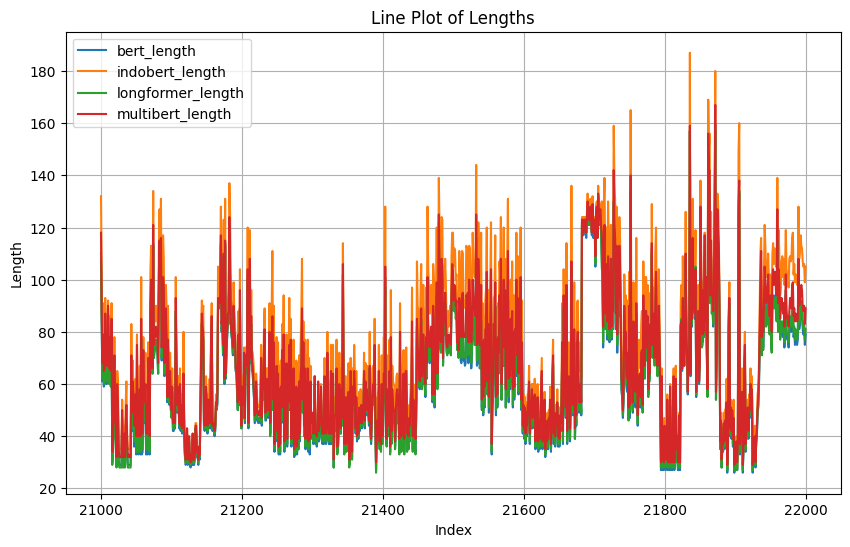

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

length_df = df[[
    "bert_length", 
    "indobert_length", 
    # "albert_length", 
    # "indoalbert_length", 
    "longformer_length", 
    "multibert_length",
    ]].copy()
length_df = length_df[21000:22000]
# length_df.info()
# Plot each column
plt.figure(figsize=(10, 6))
for column in length_df.columns:
    plt.plot(length_df.index, length_df[column], label=column)

# Add labels, legend, and title
plt.xlabel('Index')
plt.ylabel('Length')
plt.title('Line Plot of Lengths')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [10]:
print("bert_length :", df[df['bert_length']>510]['bert_length'].count())
print("indobert_length :", df[df['indobert_length']>510]['indobert_length'].count())
print("multibert_length :", df[df['multibert_length']>510]['multibert_length'].count())
print("longformer_length :", df[df['longformer_length']>510]['longformer_length'].count())

bert_length : 265
indobert_length : 313
multibert_length : 260
longformer_length : 287


In [15]:
print("bert_length :", df[df['bert_length']>254]['bert_length'].count())
print("indobert_length :", df[df['indobert_length']>254]['indobert_length'].count())
print("multibert_length :", df[df['multibert_length']>254]['multibert_length'].count())
print("longformer_length :", df[df['longformer_length']>254]['longformer_length'].count())

bert_length : 1038
indobert_length : 1050
multibert_length : 800
longformer_length : 1141


In [5]:
print("bert_length :", df[df['bert_length']>126]['bert_length'].count())
print("indobert_length :", df[df['indobert_length']>126]['indobert_length'].count())
print("multibert_length :", df[df['multibert_length']>126]['multibert_length'].count())
print("longformer_length :", df[df['longformer_length']>126]['longformer_length'].count())

bert_length : 10618
indobert_length : 14342
multibert_length : 12082
longformer_length : 11561


In [ ]:
df1 = df[df['dataset'] != 'asap']
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5363 entries, 0 to 22405
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   question           4859 non-null   object 
 1   reference_answer   5363 non-null   object 
 2   answer             5363 non-null   object 
 3   score              5363 non-null   float64
 4   dataset            5363 non-null   object 
 5   normalized_score   5363 non-null   float64
 6   normalized_score2  5363 non-null   int64  
 7   bert_length        5363 non-null   int64  
 8   indobert_length    5363 non-null   int64  
 9   albert_length      5363 non-null   int64  
 10  longformer_length  5363 non-null   int64  
 11  multibert_length   5363 non-null   int64  
 12  indoalbert_length  5363 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 586.6+ KB


In [14]:
print("bert_length :", df1[df1['bert_length']>510]['bert_length'].count())
print("indobert_length :", df1[df1['indobert_length']>510]['indobert_length'].count())
print("multibert_length :", df1[df1['multibert_length']>510]['multibert_length'].count())
print("longformer_length :", df1[df1['longformer_length']>510]['longformer_length'].count())

bert_length : 265
indobert_length : 309
multibert_length : 260
longformer_length : 287


In [16]:
print("bert_length :", df1[df1['bert_length']>254]['bert_length'].count())
print("indobert_length :", df1[df1['indobert_length']>254]['indobert_length'].count())
print("multibert_length :", df1[df1['multibert_length']>254]['multibert_length'].count())
print("longformer_length :", df1[df1['longformer_length']>254]['longformer_length'].count())

bert_length : 916
indobert_length : 477
multibert_length : 624
longformer_length : 1007


In [17]:
print("bert_length :", df1[df1['bert_length']>126]['bert_length'].count())
print("indobert_length :", df1[df1['indobert_length']>126]['indobert_length'].count())
print("multibert_length :", df1[df1['multibert_length']>126]['multibert_length'].count())
print("longformer_length :", df1[df1['longformer_length']>126]['longformer_length'].count())

bert_length : 2326
indobert_length : 1239
multibert_length : 1791
longformer_length : 2381


In [19]:
df1['bert_length'].describe()

count    5363.000000
mean      166.827335
std       176.686946
min        23.000000
25%        60.000000
50%        98.000000
75%       204.000000
max      1712.000000
Name: bert_length, dtype: float64

In [21]:
df1.to_csv("aes_dataset_5k.csv", index=False)

In [22]:
df['dataset'].value_counts()

dataset
asap              17043
sag                2558
analisis_essay     2162
stita               333
cunlp               171
sci                 139
Name: count, dtype: int64

In [3]:
df2 = df[(df['dataset'] != 'analisis_essay') & (df['dataset'] != 'asap')]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3201 entries, 19205 to 22405
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   question           2697 non-null   object 
 1   reference_answer   3201 non-null   object 
 2   answer             3201 non-null   object 
 3   score              3201 non-null   float64
 4   dataset            3201 non-null   object 
 5   normalized_score   3201 non-null   float64
 6   normalized_score2  3201 non-null   int64  
 7   bert_length        3201 non-null   int64  
 8   indobert_length    3201 non-null   int64  
 9   albert_length      3201 non-null   int64  
 10  longformer_length  3201 non-null   int64  
 11  multibert_length   3201 non-null   int64  
 12  indoalbert_length  3201 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 350.1+ KB


In [26]:
df2.to_csv("aes_dataset_enOnly.csv", index=False)

In [27]:
df2['bert_length'].describe()

count    3201.000000
mean      133.480475
std       197.648148
min        23.000000
25%        49.000000
50%        67.000000
75%        93.000000
max      1450.000000
Name: bert_length, dtype: float64

In [4]:
df2.reset_index(inplace=True)
df2.head()

,index,question,reference_answer,answer,score,dataset,normalized_score,normalized_score2,bert_length,indobert_length,albert_length,longformer_length,multibert_length,indoalbert_length
0,19205,NaN,"If the question is IR-Based, I will do the fol...",Using semantic analysis methods. We can use ve...,25.0,cunlp,0.25,25,226,273,234,225,236,280
1,19206,NaN,"If the question is IR-Based, I will do the fol...","we should use vector space model. firstly, bin...",25.0,cunlp,0.25,25,249,299,259,259,259,307
2,19207,NaN,"If the question is IR-Based, I will do the fol...","Assume we have a question like "" Why the sky i...",50.0,cunlp,0.50,50,274,331,284,285,289,341
3,19208,NaN,"If the question is IR-Based, I will do the fol...",We can use Vector Space Model that is represen...,25.0,cunlp,0.25,25,300,377,310,309,316,386
4,19209,NaN,"If the question is IR-Based, I will do the fol...",In this corpus we will use sentence segmenting...,50.0,cunlp,0.50,50,289,346,297,296,300,355


In [5]:
from transformers import AutoTokenizer, BertTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dataset = EssayDataset(df2, tokenizer, 512)
df2['question_bert'], df2['reference_bert'], df2['student_bert'] = zip(
    *df2.index.map(lambda idx: dataset.get_each_length(idx))
)

Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors
C:\Users\User\AppData\Local\Temp\ipykernel_25908\2884193002.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['question_bert'], df2['reference_bert'], df2['student_bert'] = zip(
C:\Users\User\AppData\Local\Temp\ipykernel_25908\2884193002.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['question_bert'], df2['referen

In [25]:
df2[df2['student_bert'] > 200].count()

index                155
question               0
reference_answer     155
answer               155
score                155
dataset              155
normalized_score     155
normalized_score2    155
bert_length          155
indobert_length      155
albert_length        155
longformer_length    155
multibert_length     155
indoalbert_length    155
question_bert        155
reference_bert       155
student_bert         155
dtype: int64

In [33]:
df2['reference_bert'].describe()

count    3201.000000
mean       71.126523
std       132.827574
min         7.000000
25%        15.000000
50%        23.000000
75%        39.000000
max       725.000000
Name: reference_bert, dtype: float64

In [34]:
df2['student_bert'].describe()

count    3201.000000
mean       50.303343
std        79.684449
min         6.000000
25%        16.000000
50%        26.000000
75%        43.000000
max       724.000000
Name: student_bert, dtype: float64